### Single-particle tracking pipeline for 2D data
Input: 
> Set of localizations, currently accepting ThunderStorm format \
> You need to change some of the parameters here and there; the text before the code cells will tell you \

Output:  
 >   1. Linked trajectories
  >  2. MSD analysis/graphs with trackpy
   > 3. MSD fits (D*, alpha) with graphs
>

Dependencies:
> matplotlib, pandas, numpy \
> trackpy, scipy, seaborn

#### Load all packages

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt, pandas as pd, numpy as np     # all necessary

# Only need trackpy for tracking
import trackpy as tp

from scipy.optimize import curve_fit
import seaborn as sns

import os


#### Initialize all the functions

In [31]:
def load_locs(dir,fn, conv_factor):
    locs = pd.read_csv(dir+fn)
    locs = locs[["frame","x [nm]","y [nm]"]].rename(columns={"x [nm]": "x", "y [nm]": "y"}, errors = 'raise')

    conv_factor = conv_factor
    locs = locs.mul({'frame':1,'x':conv_factor,'y':conv_factor})  # convert to um
    locs['file'] = fn
    return locs
    
def track_and_filter(locs, search_range, memory, min_track):
    trajs = tp.link(locs, search_range, memory = memory, link_strategy = 'auto')      # trackpy links with the Crocker & Grier algorithm
    # Filter out spurious tracks
    tracks = tp.filter_stubs(trajs, min_track)  
    plt.figure()
    tp.plot_traj(tracks, mpp = 1)
    return tracks

def calc_imsds(tracks, mpp, fps, maxlag, fn):
    im = tp.imsd(tracks, mpp, fps, max_lagtime = maxlag)
    fig, ax = plt.subplots()
    ax.plot(im.index, im, 'k-', alpha=0.3)  # black lines, semitransparent
    ax.set(ylabel=r'MSD [$\mu$m$^2$]',
           xlabel='lag time $t (s)$')
    ax.set_yscale('linear')
    ax.set_xscale('linear')
    ax.set_ylabel('MSD (um^2)')
    ax.set_title('iMSDs')
    #ax.set_ylim([0, 0.0075])
    #ax.set_xticks([0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    ax.set_xticks([0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8])
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    plt.savefig(fn)
    return im

def msd_2D_log(lag, D_eff,  alpha, sigma):
    #t_exp = 0.05
    return np.log((4*D_eff*np.power(lag,alpha)) + 2*np.power(sigma,2))

def msd_2D(lag, D_eff,  alpha, sigma):
    #t_exp = 0.05
    return ((4*D_eff*np.power(lag,alpha)) + 2*np.power(sigma,2))

from matplotlib.lines import Line2D
import warnings
def fit_imsds(im, t_exp, fn):
    fits = pd.DataFrame()
    fits.index = im.index
    xdata = im.index.to_numpy() 
    bounds=([0.000001, 0.01, 0.001], [0.01, 2., 0.1])
    p0 = [0.001,0.5,0.001]
    
    params = pd.DataFrame()
    params.index = ['D_eff', 'alpha', 'sigma']
    for i in im.columns:   
        popt, pcov = curve_fit(msd_2D_log, xdata, np.log(im[i].to_numpy()), bounds=bounds, p0 = p0, maxfev=5000)
        fits['Fit of ' + str(i)] = msd_2D(xdata,*popt)
        params[i] = popt

    ax = im.plot(style = 'k-',alpha = 0.2, linewidth = 2)
    warnings.filterwarnings('ignore')
    fits.plot(ax=ax,style = 'k--',alpha = 0.6, linewidth = 2)
    warnings.filterwarnings('ignore')
    plt.yscale('linear')
    plt.xscale('linear')
    plt.ylabel('MSD (um^2)')
    plt.title('Fit to 2D MSD')
    #plt.ylim([0, 0.0075])
    #ax.set_xticks([0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    #ax.set_xticks([0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8])
    lined = Line2D([0], [0], label='Data', color='k', linestyle = '-')
    linef = Line2D([0], [0], label='Fit', color='k', linestyle = '--')
    plt.legend(handles=[lined, linef])
    plt.savefig(fn)
    return params

def plot_scatter(params,fn):
    params.transpose().plot.scatter('D_eff','alpha', c = 'k')
    plt.xscale('log')

def plot_violin(params,fn):
    from matplotlib import ticker as mticker

    params = params.transpose()
    data = params['D_eff'].values
    log_data = [np.log10(d) for d in data]
    
    fig, ax = plt.subplots(ncols=2, figsize=(7, 7), sharey=False)
    sns.stripplot(data=log_data, ax=ax[0], jitter = True, color = 'black',alpha = 0.5)
    sns.violinplot(data=log_data, ax=ax[0])
    
    ax[0].yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
    ymin, ymax = ax[0].get_ylim()
    tick_range = np.arange(np.floor(ymin), ymax)
    ax[0].yaxis.set_ticks(tick_range)
    ax[0].yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
    ax[0].title.set_text('Diffusion Coefficient')
    ax[0].set_ylabel('(um ^ 2)/ (sec ^ alpha)')
    
    data = params['alpha'].values
    
    
    sns.stripplot(data=data, ax=ax[1], jitter = True, color = 'black',alpha = 0.5)
    sns.violinplot(data=data, ax=ax[1], color = 'orange')
    #ax[0].yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
    #ymin, ymax = ax[1].get_ylim()
    #tick_range = np.arange(np.floor(ymin), ymax)
    #ax[1].yaxis.set_ticks(tick_range)
    #ax[0].yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
    ax[1].title.set_text('Anomolous Exponent')
    ax[1].set_ylabel('au')
    
    plt.tight_layout()
    plt.savefig(fn)
    plt.show()

### Load files
> change dir to folder housing the data

In [10]:
dir = "C:\\Users\\ar138\\Desktop\\Research\\Codes\\chromtrack\\telomeres\\"
filenames = os.listdir(dir)
print(filenames)

['cell0.csv', 'cell2.csv', 'cell3.csv', 'cell4.csv', 'cell5.csv']


### Load localizations
>Change "conv_factor" to your pixel size, assuming input data is in pixels (if in um, set to 1)

In [12]:
all_locs = pd.DataFrame()
conv_factor = 0.13        # um / pix
for i,fn in enumerate(filenames):
    locs = load_locs(dir,fn,conv_factor) 
    locs['x'] = locs['x'] + i*10
    locs['y'] = locs['y'] + i*10
    all_locs= pd.concat([all_locs, locs], ignore_index=True)
    
all_locs.head()

,frame,x,y,file
0,1.0,4.777724,10.419703,cell0.csv
1,1.0,5.236120,4.608648,cell0.csv
2,1.0,6.862084,7.918792,cell0.csv
3,1.0,7.008581,6.849670,cell0.csv
4,1.0,7.786022,4.516208,cell0.csv


### Track things
> "max_dist" : maximum allowed step size of a particle (in um) \
> "max_off" : maximum allowed off frames to stille be counted as the same particle (in frames) \
> "min_track" : minimum track length (in frames)

Frame 1000: 115 trajectories present.


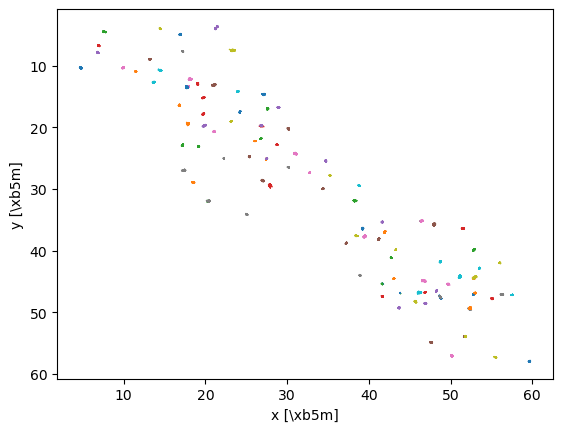

In [28]:
max_dist = 0.26
max_off = 5
min_track = 200
all_tracks = track_and_filter(all_locs, max_dist, max_off, min_track)
#plt.savefig('test.png')

### Calculate MSDs
> "fps" : video rate \
> "max_lag" : maximum lag to calculate MSD to (in frames) 

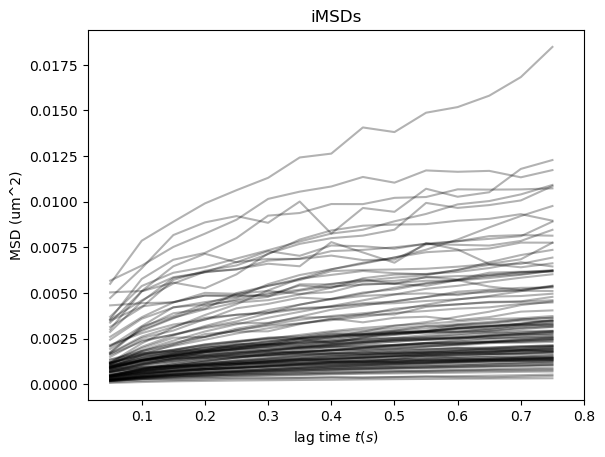

In [29]:
fps = 20
max_lag = 15
ims = calc_imsds(all_tracks, 1, fps, max_lag, 'test.png')

### Fit MSDs
and plot things

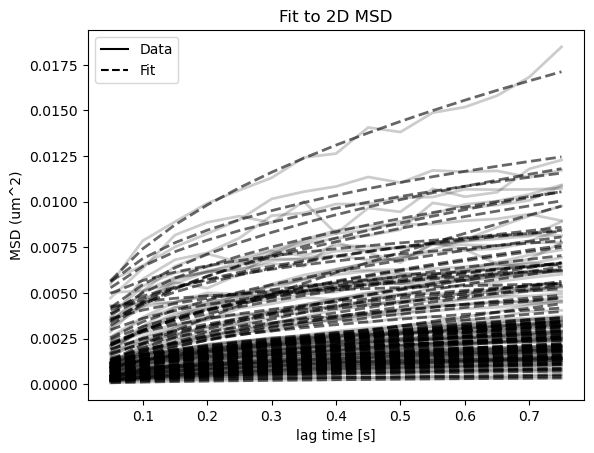

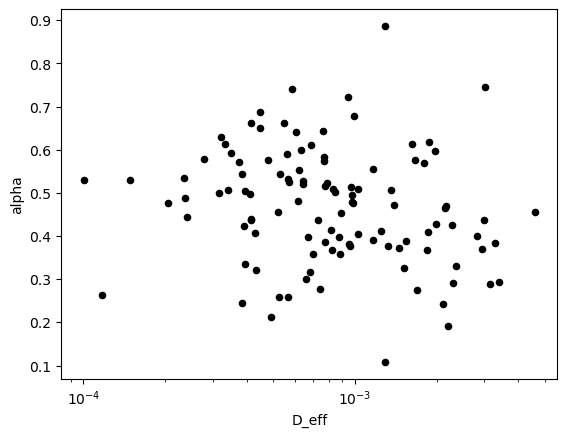

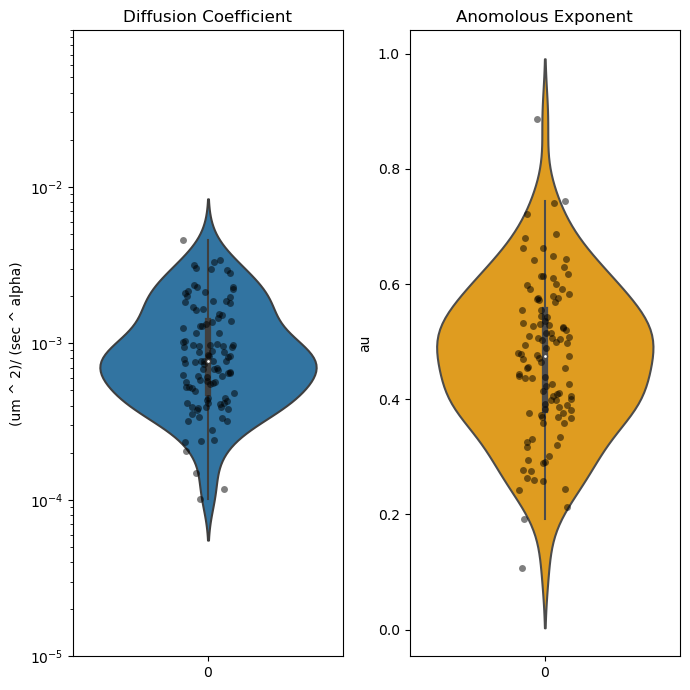

In [32]:
params = fit_imsds(ims,1/fps,'test.png')
plot_scatter(params,'test.png')
plot_violin(params,'test.png')